# Sequence prediction find most similar

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

In [2]:
CONFIG_PATH = '/root/work/artwork_sequence/train_test_configuration'

In [3]:
window_index = 3

museum_sequence_path = {
    'x_train' : os.path.join(CONFIG_PATH, 'X_train.csv'),
    'x_test' : os.path.join(CONFIG_PATH, 'X_test.csv'),
    'x_train_matrix' : os.path.join(CONFIG_PATH, 'X_train_matrix.npy'),
    'x_test_matrix' : os.path.join(CONFIG_PATH, 'X_test_matrix.npy'),
    'weights_folder' : os.path.join(CONFIG_PATH, 'config_'+str(window_index)+'/trained_model_weights')
}
museum_sequence_path

{'weights_folder': '/root/work/artwork_sequence/train_test_configuration/config_3/trained_model_weights',
 'x_test': '/root/work/artwork_sequence/train_test_configuration/X_test.csv',
 'x_test_matrix': '/root/work/artwork_sequence/train_test_configuration/X_test_matrix.npy',
 'x_train': '/root/work/artwork_sequence/train_test_configuration/X_train.csv',
 'x_train_matrix': '/root/work/artwork_sequence/train_test_configuration/X_train_matrix.npy'}

## Load data

In [5]:
df_x_train = pd.read_csv(museum_sequence_path['x_train'], index_col=0)
df_x_test = pd.read_csv(museum_sequence_path['x_test'], index_col=0)
x_train_matrix = np.load(museum_sequence_path['x_train_matrix'])
x_test_matrix = np.load(museum_sequence_path['x_test_matrix'])
df_x_train.head()

,tour_path
20,/root/work/datasets/artwork_sequence/rijksmuse...
7,/root/work/datasets/artwork_sequence/rijksmuse...
40,/root/work/datasets/artwork_sequence/prado_cra...
0,/root/work/datasets/artwork_sequence/rijksmuse...
23,/root/work/datasets/artwork_sequence/prado_cra...


In [6]:
x_train_matrix.shape

(637, 300)

## Reset Tensorflow session

In [7]:
tf.keras.backend.clear_session()

## Config data to fit with the model input

**Define timeline**

In [8]:
timeline = np.arange(x_test_matrix.shape[0])
timeline.shape

(222,)

In [9]:
split_time = x_train_matrix.shape[0]

X = x_test_matrix

window_size = window_index

batch_size = 128
shuffle_buffer_size = 300

## Create and Load model

**Helper function to load weights**

In [10]:
def load_weights(model, index, museum_sequence_path):
    #Find the folder where the weights are saved
    model_feature_folder = os.path.join(museum_sequence_path['weights_folder'], 'model_feature_'+str(index))    
    #Load weights
    model.load_weights(os.path.join(model_feature_folder, 'weights_feature_'+str(index)))
    return model

**Get models**

In [11]:
from Prediction_model_feature import Prediction_model_feature

In [12]:
n_features = X.shape[1]
models = []

In [13]:
from IPython.display import clear_output
import time

start_time = time.time()

for i in range(n_features):
    clear_output(wait=True)
    #Create model
    model_prediction = Prediction_model_feature(
        X=X[:, 0],
        split_time=split_time,
        train_batch_size=batch_size, 
        val_batch_size=batch_size, 
        window_size=window_size, 
        shuffle_buffer=shuffle_buffer_size,
        name="feature " + str(0))
    model = model_prediction.get_model()
    #Load weights
    model =load_weights(model, i, museum_sequence_path)
    models.append(model)
    
print("--- %s seconds ---" % (time.time() - start_time))
len(models)

--- 443.4200155735016 seconds ---


300

## Predict tour

In [14]:
from utils_plot import plot_series, plot_train_history, plot_prediction

**Select a tour**

In [88]:
df_x_test['tour_path'].values[0]

'/root/work/datasets/artwork_sequence/prado_crawler/tour_18'

In [15]:
images_path = os.path.join(df_x_test['tour_path'].values[0], 'images')
tour_length = len(os.listdir(images_path))
X_tour = x_test_matrix[:tour_length]
X_tour.shape

(13, 300)

### Predict features artworks for each tours

**Function to predict the tour**

In [16]:
def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda w: (w[:]))
    ds = ds.batch(batch_size)
    forecast = model.predict(ds)
    return forecast

**Predict feature tours**

In [17]:
df_evaluation = pd.DataFrame({'feature' : [],
                             'forecast': [],
                             'x_valid':[],
                             'mae':[]})
df_evaluation

,feature,forecast,mae,x_valid


In [19]:
for feature in range(n_features):
    #Predict feature i
    x_feature = X_tour[:,feature]
    rnn_forecast = model_forecast(models[feature], x_feature, window_size, batch_size)
    rnn_forecast = rnn_forecast[1:,-1,0]

    #Get validation dataset 
    x_valid = x_feature[window_size:]

    #Compute MAE
    mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy().mean()

    df_evaluation = df_evaluation.append({'feature' : feature,
                    'forecast': rnn_forecast,
                    'x_valid':x_valid,
                    'mae':mae
                   }, 
                   ignore_index=True)

df_evaluation.head()

,feature,forecast,mae,x_valid
0,0.0,"[0.7779827, 0.6571379, 0.7676119, 0.849713, 1....",0.807985,"[-0.29230052, 0.8424356, 1.1737278, 1.2865187,..."
1,1.0,"[0.43910006, 0.42740887, 0.38457522, 0.3830193...",0.356716,"[-0.059978914, 0.28663373, 0.14912537, 1.05441..."
2,2.0,"[0.83216864, 0.7574638, 0.7590108, 0.7455342, ...",0.451865,"[1.507407, 0.46375805, 0.7856071, 1.6591117, 1..."
3,3.0,"[0.85672194, 0.79068613, 0.8290143, 0.79601055...",0.178212,"[0.73924804, 0.7568244, 0.559912, 1.042276, 0...."
4,4.0,"[0.8756848, 0.895782, 0.75910556, 0.7516807, 0...",0.380421,"[0.21867388, 0.31268334, 0.8486078, 0.909141, ..."


In [27]:
df_evaluation['mae'].mean()

0.38374367121607067

**Plot forecast for a single feature**

In [22]:
feature = 5
rnn_forecast = df_evaluation.loc[feature,'forecast']
#discard the first artworks
x_valid = df_evaluation.loc[feature,'x_valid']
timeline = np.arange(rnn_forecast.shape[0])

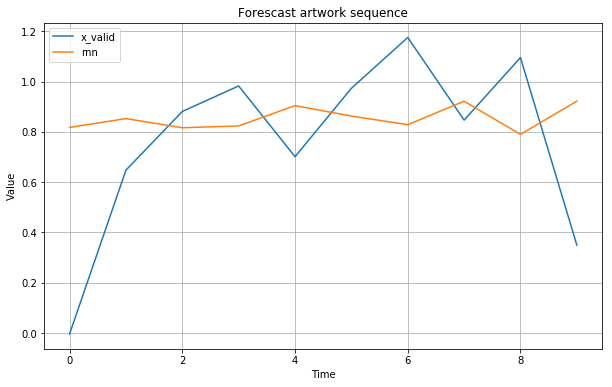

In [23]:
plot = plot_series(timeline, [(x_valid, 'x_valid'), (rnn_forecast, 'rnn')])
plot.title('Forescast artwork sequence')
#plot.savefig(os.path.join(PLOT_PATH, 'forescast_sequence_2.png'))
plot.show()

## Find most similar artwork

**Load artwork's repository**

In [24]:
BASE_PATH = '/root/work/datasets/artwork_sequence/'

In [25]:
df_all_metadata = pd.read_csv(os.path.join(BASE_PATH, 'all_metadata.csv'))
all_data_matrix = np.load(os.path.join(BASE_PATH, 'all_code_matrix.npy' ))

In [26]:
print(df_all_metadata.shape)
print(all_data_matrix.shape)

(633, 6)
(633, 300)


**Reconstruct predicted codes**

In [28]:
forescast = df_evaluation['forecast']
forescast.head()

0    [0.7779827, 0.6571379, 0.7676119, 0.849713, 1....
1    [0.43910006, 0.42740887, 0.38457522, 0.3830193...
2    [0.83216864, 0.7574638, 0.7590108, 0.7455342, ...
3    [0.85672194, 0.79068613, 0.8290143, 0.79601055...
4    [0.8756848, 0.895782, 0.75910556, 0.7516807, 0...
Name: forecast, dtype: object

In [29]:
feature_list = list(forescast.values)

In [30]:
forecast_matrix = np.stack(feature_list)
forecast_matrix = forecast_matrix.T
forecast_matrix.shape

(10, 300)

**Compute cosine similarity**

In [106]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances,euclidean_distances

In [163]:
df_all_metadata.iloc[sim_artwork_index]

id                                                           1
author                                         pieter de hooch
data                                                      1663
image_url    https://lh3.googleusercontent.com/7aWk-x_VNb_Y...
title              interior with women beside a linen cupboard
tour_path    /root/work/datasets/artwork_sequence/rijksmuse...
Name: 89, dtype: object

In [164]:
df_all_metadata.iloc[sim_artwork_index]['tour_path']

'/root/work/datasets/artwork_sequence/rijksmuseum_crawler/tour_20'

In [113]:
df_all_metadata.iloc[sim_artwork_index]['image_url']

'https://lh3.googleusercontent.com/7aWk-x_VNb_Y1-X8C38nVnZAgmyAGUWDmOIAYiHKVtZG55xUggHFjQ-8l49nCuF_VJFFh2W57yMJrRq2SVNctSFYL7o=w400'

In [172]:
df_tour = pd.DataFrame({ 'title' : [],
                         'author' : [],
                         'sim_value' : [],
                         'tour_path': [],
                         'image_url':[]})
df_tour

,author,image_url,sim_value,title,tour_path


In [176]:

for i in range(forecast_matrix.shape[0]):
    #Find code
    code = forecast_matrix[i].reshape((1,-1))
    
    #Compute cosine similarity
    sim_matrix = cosine_similarity(code, all_data_matrix)
    #sim_matrix = euclidean_distances(code, all_data_matrix)
    
    #sort indexes
    sort_index = np.argsort(sim_matrix.reshape((-1,)))
    
    #Find most similar
    sim_artwork_index = sort_index[-1]
    
    #Save in dataframe 
    df_tour= df_tour.append({'title' : df_all_metadata.iloc[sim_artwork_index]['title'],
                    'author': df_all_metadata.iloc[sim_artwork_index]['author'],
                    'tour_path':df_all_metadata.iloc[sim_artwork_index]['tour_path'],
                    'image_url':df_all_metadata.iloc[sim_artwork_index]['image_url'],
                    'sim_value':sim_matrix[:,sim_artwork_index]
                   }, 
                   ignore_index=True)
    

df_tour

,author,image_url,sim_value,title,tour_path
0,pieter de hooch,https://lh3.googleusercontent.com/7aWk-x_VNb_Y...,[0.91927314],interior with women beside a linen cupboard,/root/work/datasets/artwork_sequence/rijksmuse...
1,pieter de hooch,https://lh3.googleusercontent.com/7aWk-x_VNb_Y...,[0.9110239],interior with women beside a linen cupboard,/root/work/datasets/artwork_sequence/rijksmuse...
2,pieter de hooch,https://lh3.googleusercontent.com/7aWk-x_VNb_Y...,[0.91427857],interior with women beside a linen cupboard,/root/work/datasets/artwork_sequence/rijksmuse...
3,pieter de hooch,https://lh3.googleusercontent.com/7aWk-x_VNb_Y...,[0.9361559],interior with women beside a linen cupboard,/root/work/datasets/artwork_sequence/rijksmuse...
4,pieter de hooch,https://lh3.googleusercontent.com/7aWk-x_VNb_Y...,[0.9330392],interior with women beside a linen cupboard,/root/work/datasets/artwork_sequence/rijksmuse...
5,pieter de hooch,https://lh3.googleusercontent.com/7aWk-x_VNb_Y...,[0.9171705],interior with women beside a linen cupboard,/root/work/datasets/artwork_sequence/rijksmuse...
6,pieter de hooch,https://lh3.googleusercontent.com/7aWk-x_VNb_Y...,[0.9164647],interior with women beside a linen cupboard,/root/work/datasets/artwork_sequence/rijksmuse...
7,pieter de hooch,https://lh3.googleusercontent.com/7aWk-x_VNb_Y...,[0.92137855],interior with women beside a linen cupboard,/root/work/datasets/artwork_sequence/rijksmuse...
8,pieter de hooch,https://lh3.googleusercontent.com/7aWk-x_VNb_Y...,[0.9189795],interior with women beside a linen cupboard,/root/work/datasets/artwork_sequence/rijksmuse...
9,pieter de hooch,https://lh3.googleusercontent.com/7aWk-x_VNb_Y...,[0.9267774],interior with women beside a linen cupboard,/root/work/datasets/artwork_sequence/rijksmuse...


**Cosine similarity between predicted and true artwork**

In [165]:
x_valid_artwork = df_evaluation['x_valid']
x_valid_artwork.head()

0    [-0.29230052, 0.8424356, 1.1737278, 1.2865187,...
1    [-0.059978914, 0.28663373, 0.14912537, 1.05441...
2    [1.507407, 0.46375805, 0.7856071, 1.6591117, 1...
3    [0.73924804, 0.7568244, 0.559912, 1.042276, 0....
4    [0.21867388, 0.31268334, 0.8486078, 0.909141, ...
Name: x_valid, dtype: object

In [166]:
artwork_feature_list = list(x_valid_artwork.values)
artwork_matrix = np.stack(artwork_feature_list)
artwork_matrix = artwork_matrix.T
artwork_matrix.shape

(10, 300)

In [167]:
true_artwork_code = artwork_matrix[3].reshape((1,-1))
true_artwork_code.shape

(1, 300)

In [168]:
cos_sim = cosine_similarity(code, true_artwork_code)[0][0]
cos_sim

0.841828

In [135]:
np.argwhere(sim_matrix == cos_sim)

array([[  0, 537]])